In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 8)
from FEM_func import *
from plotting import *

## SET UP MESH

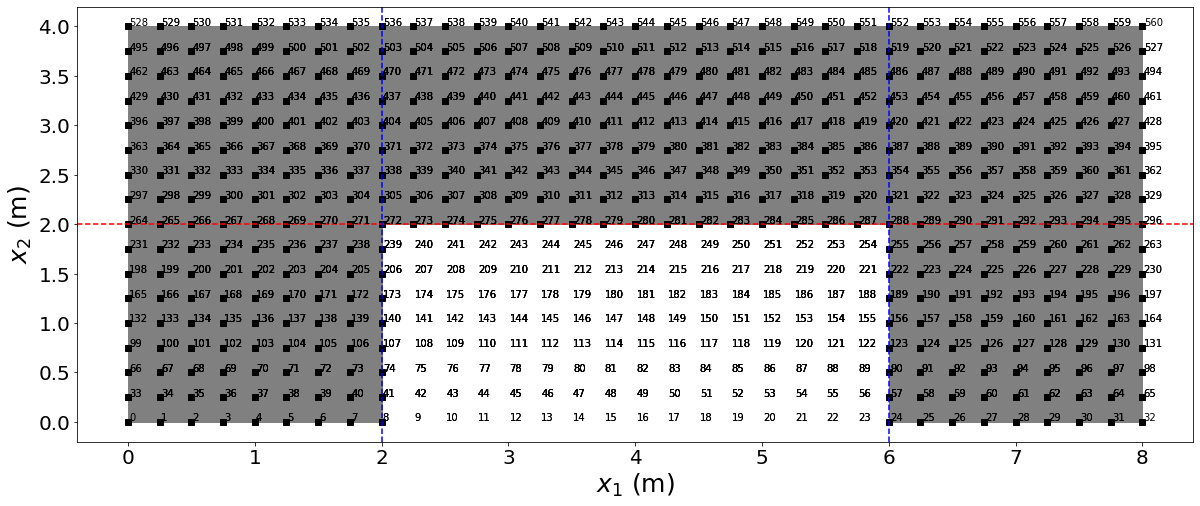

Number of Nodes =  561
Number of Elements = 512


In [2]:
### MESH SET UP

### MINIMUM NUMBER OF HORIZONTAL NODES
M=4

### VARY MESH_DENSITY LEVEL TO VARY NUMBER OF ELEMENTS 
mesh_density_lvl = 6
el_axis = 2**(mesh_density_lvl)
elements = M*el_axis

### USE MODULAR ARITHMITIC TO CREATE GRIDS FROM ABOVE DATA
mod = 2
delta_x = M
delta_y = 2

mod_condition = np.log2(elements/M)

if elements == M:
    bot, top, right, left = create_grid(delta_x, delta_y)
else:
    for i in range(int(mod_condition)):
        if mod % 2 == 0:
            delta_y *= 2
            mod += 1
        else:
            delta_x *= 2
            mod += 1
    bot, top, right, left = create_grid(delta_x, delta_y)
    
### PRODUCE MESH
XYZ, CON, DOF, nelx, nely = mesh(bot,top,left,right)

### NUMBER OF NODES AND ELEMENTS
nnodes = len(XYZ)
nels = len(CON)

### PLOT INITIAL GRID
if mesh_density_lvl <= 8:
    initial_grid(XYZ, CON)

print('Number of Nodes = ', nnodes)
print('Number of Elements =', nels)

## GRID SPECIFICS

In [3]:
### YOUNGS MODULUS
E =75e9
### POISSION RATIO
nu = 0.32
### OUT OF PLANE THICKNESS
th = 5
### DEGRESS OF FREEDOM PER ELEMENT
ndof = 8
### NUMBER OF INTEGRATION POINTS
nip = 4

### DELTA X1
L_x1 = XYZ[1][0]-XYZ[0][0]

### DELTA X2
L_x2 = XYZ[1][1]-XYZ[0][1]

## GLOBAL FORCES 
$$
F_{g} = \sum_{i = 1}^{n_e} L_{e,i}^{T} f_{e,i} L_{e,i}
$$

$$
f_e = \int_{\Gamma_{34}} \mathbf{N}^{eT} \mathbf{t} \,\, d{\Gamma} = \int_{l+l_e}^{l+2l_e} \mathbf{N}^{eT}(\xi, \eta = 1) \mathbf{t} \,\, d{x_1}
$$

where $l_e$ is the element length in $x_1$ direction.

Convert from real to natural coordinates: $a\leq x_1 \leq b \, ; \, -1\leq \xi \leq 1$

$$
x_1 = \frac{1}{2}(a + b) + \frac{1}{2}\xi(b-a) = \frac{1}{2}(2l + 3l_e) = \frac{l_e}{2}\xi \rightarrow dx_1 = \frac{l_e}{2} d\xi
$$


Only care for node 3 and 4 as we are integrating over edge 3-4, thus shape functions become:

$$
\mathbf{N}^{eT}(\xi, \eta = 1) = \frac{1}{2}\begin{bmatrix}
0 & 0 \\
0 & 0 \\
0 & 0 \\
0 & 0 \\
1+\xi & 0 \\
0 & 1+\xi\\
1 - \xi & 0 \\
0 & 1-\xi \\
\end{bmatrix}
$$

as 
$$
N_{i}^{e}(\xi, \eta) = \frac{1}{4}\left(1+\xi_{i}\xi\right)\left(1+\eta_{i}\eta\right)
$$

$$
(\xi_{i}, \eta_{i}): i = 1 \,\, (\xi_{1} = -1, \eta_{1} = -1) \,\, ; i = 2 \,\, (\xi_{2} = 1, \eta_{2} = -1) \,\, ; i = 3 \,\, (\xi_{3} = 1, \eta_{3} = 1) \,\, ; i = 4 \,\, (\xi_{4} = -1, \eta_{4} = 1)   
$$

and the shape function matrix is defined as:

$$
\mathbf{N}^e = \begin{bmatrix}
N^e_1 & 0 & N^e_2 & 0 & N^e_3 & 0 & N^e_4 & 0 \\
0 & N^e_1 & 0 & N^e_2 & 0 & N^e_3 & 0 & N^e_4 \\
\end{bmatrix}
$$



The traction for this problem is given as:

$$
\mathbf{t} = \begin{bmatrix}
0 \\
-150\\
\end{bmatrix}Nm^{-1}
$$

Therefore:
$$
f_e = \frac{l_e}{2}\int_{-1}^{1} \frac{1}{2}\begin{bmatrix}
0 & 0 \\
0 & 0 \\
0 & 0 \\
0 & 0 \\
1+\xi & 0 \\
0 & 1+\xi\\
1 - \xi & 0 \\
0 & 1-\xi \\
\end{bmatrix}
\begin{bmatrix}
0 \\
-150\\
\end{bmatrix}
\,\, d{\xi}
=\frac{l_e}{2}\begin{bmatrix}
0 & 0 \\
0 & 0 \\
0 & 0 \\
0 & 0 \\
1 & 0 \\
0 & 1\\
1 & 0 \\
0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
0 \\
-150\\
\end{bmatrix}
= \frac{l_e}{2}\begin{bmatrix}
0  \\
0 \\
0 \\
0 \\
0 \\
-150\\
0\\
-150\\
\end{bmatrix}
N
$$

In [4]:
### FORCE ONLY APPLIED TO TOP NODES
force_con = nnodes - len(top)

f = {}

### ELEMENTAL FORCES

for i in range(nels):
    
    f[i] = np.zeros(nip)
    
    if  i < nels - nelx:
        force = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    else : 
        force = [0.0, 0.0, 0.0, 0.0, 0.0, (-150.0)*(L_x1/2.0), 0.0, (-150.0)*(L_x1/2.0)]
        
    f[i] = force

f_g = np.zeros(2*nnodes)

### GLOBAL FORCES
for i in range(nels):

    f_g[np.ix_(DOF[i])] += f[i]


f_g = np.array(f_g)

f_g = f_g.reshape((2*nnodes, 1))


print('Sum of Forces (Traction) =', np.sum(f_g), 'N')

Sum of Forces (Traction) = -1200.0 N


### NON-ZERO DISPLACEMENT NODES

In [5]:
### FIND NODES WHICH ARE NON-ZERO

bcnodes = []
for i in range(nnodes):
    ### NODES ARE FIXED AT THE BOTTOM == 0
    if i < len(bot):
        bcnodes.append(i)
    ### NODES IN EMPTY SPACE MUST NOT MOVE == 0
    if 2.0<XYZ[i,0]<6.0 and 0.0<=XYZ[i,1]<2.0:
        bcnodes.append(i)
        
bcnodes = np.array(bcnodes)
bcdof = np.zeros(len(bcnodes)*2,dtype=int)
for i in range(len(bcnodes)):
    bcdof[2*i] = bcnodes[i]*2
    bcdof[2*i+1] = bcnodes[i]*2+1
    
### FIND NON-ZERO INDICIES    
bc = np.ones((2*nnodes),dtype=int)
bc[bcdof] = 0
d_nz = bc.nonzero()
d_nz = np.array(d_nz).reshape(-1)

# print('Non-Zero displacements =', d_nz)

### LINEAR ELASTICITY CONDITION - PLANE STRAIN

$$
C = \frac{E}{(1+\nu)(1-2\nu)}\begin{bmatrix}
1-\nu & \nu & 0 \\
\nu & 1- \nu & 0 \\
0 & 0 & \frac{1}{2}(1-2\nu) \\
\end{bmatrix}
$$

In [6]:
### ELASTICITY MATRIX

C = plane_strain(E,nu)

print('C =', C)

C = [[1.07323232e+11 5.05050505e+10 0.00000000e+00]
 [5.05050505e+10 1.07323232e+11 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.84090909e+10]]


## SET UP QUADRILATERAL FINITE ELEMENT

Integration Points Gauss Quadrature
$$
(\xi_{ip}, \eta_{ip}): i = 1 \,\, (\xi_{1} = -1/\sqrt{3}, \eta_{1} = -1/\sqrt{3}) \,\, ; i = 2 \,\, (\xi_{2} = 1/\sqrt{3}, \eta_{2} = -1/\sqrt{3}) \,\, ; i = 3 \,\, (\xi_{3} = 1/\sqrt{3}, \eta_{3} = 1/\sqrt{3}) \,\, ; i = 4 \,\, (\xi_{4} = -1/\sqrt{3}, \eta_{4} = 1/\sqrt{3})   
$$


In [7]:
### GAUSS POINTS
p = 1/np.sqrt(3)
gp = np.array([[-p,-p],[p,-p],[p,p],[-p,p]])

## JACOBIAN 

$$
\mathbf{J}^e = \begin{bmatrix}
\frac{\partial x_1}{\partial \xi} & \frac{\partial x_2}{\partial \xi} \\
\frac{\partial x_1}{\partial \eta} & \frac{\partial x_2}{\partial \eta} \\
\end{bmatrix}
=
\begin{bmatrix}
\frac{\partial N_{1}^{e}}{\partial \xi} & \frac{\partial N_{2}^{e}}{\partial \xi} & \frac{\partial N_{3}^{e}}{\partial \xi} \frac{\partial N_{4}^{e}}{\partial \xi} \\ 
\frac{\partial N_{1}^{e}}{\partial \eta} & \frac{\partial N_{2}^{e}}{\partial \eta} & \frac{\partial N_{3}^{e}}{\partial \eta} \frac{\partial N_{4}^{e}}{\partial \eta} \\ 
\end{bmatrix}
\begin{bmatrix}
c^{e}_{1(1)} & c^{e}_{2(1)}\\
c^{e}_{1(2)} & c^{e}_{2(2)}\\
c^{e}_{1(3)} & c^{e}_{2(3)}\\
c^{e}_{1(4)} & c^{e}_{2(4)}\\
\end{bmatrix}
$$

where $\mathbf{c}^e$ is the coordinates of the element and the shape function natural derivatives are 

$$
\begin{bmatrix}
\frac{\partial N_{1}^{e}}{\partial \xi} & \frac{\partial N_{2}^{e}}{\partial \xi} & \frac{\partial N_{3}^{e}}{\partial \xi} \frac{\partial N_{4}^{e}}{\partial \xi} \\ 
\frac{\partial N_{1}^{e}}{\partial \eta} & \frac{\partial N_{2}^{e}}{\partial \eta} & \frac{\partial N_{3}^{e}}{\partial \eta} \frac{\partial N_{4}^{e}}{\partial \eta} \\ 
\end{bmatrix}
=
\frac{1}{4}\begin{bmatrix}
\eta - 1 &  1 - \eta & 1+\eta & -\eta-1 \\
\xi - 1 &  1 -\xi & 1+\xi & 1-\xi \\
\end{bmatrix}
$$


## SHAPE FUNCTION DERIVATIVE
$$
\frac{\partial \mathbf{N}^{e}_{I}}{\partial \mathbf{x}^e} = \begin{bmatrix}
\frac{\partial N_{1}^{e}}{\partial x_1} & \frac{\partial N_{2}^{e}}{\partial x_1} & \frac{\partial N_{3}^{e}}{\partial x_1} \frac{\partial N_{4}^{e}}{\partial x_1} \\ 
\frac{\partial N_{1}^{e}}{\partial x_2} & \frac{\partial N_{2}^{e}}{\partial x_2} & \frac{\partial N_{3}^{e}}{\partial x_2} \frac{\partial N_{4}^{e}}{\partial x_2} \\ 
\end{bmatrix}
=\frac{1}{4}\left(\mathbf{J}^e\right)^{-1}\begin{bmatrix}
\eta - 1 &  1 - \eta & 1+\eta & -\eta-1 \\
\xi - 1 &  1 -\xi & 1+\xi & 1-\xi \\
\end{bmatrix}
$$

In [8]:
### JACOBIAN DETERMINANT AND SHAPE FUNCTION DERIVATIVE FOR EACH ELEMENT
detJ = {}
dN_dx = {}
for i in range(nels):
    for j in range(nip):
        detJ[i,j],dN_dx[i,j] = Jacobian_dN_dx(XYZ[CON[i]],gp[j,:])


## STRAIN DISPLACEMENT MATRIX 

$$
\mathbf{B}^e = \mathbf{\nabla_{s}}\mathbf{N}^e = \begin{bmatrix}
\frac{\partial}{\partial x_1} & 0 \\
0 & \frac{\partial}{\partial x_2} \\
\frac{\partial}{\partial x_2} & \frac{\partial}{\partial x_1}\\
\end{bmatrix}
\begin{bmatrix}
N^e_1 & 0 & N^e_2 & 0 & N^e_3 & 0 & N^e_4 & 0 \\
0 & N^e_1 & 0 & N^e_2 & 0 & N^e_3 & 0 & N^e_4 \\
\end{bmatrix}
$$

Ending with:

$$
\mathbf{B}^e = 
\begin{bmatrix}
\frac{\partial N_{1}^{e}}{\partial x_1} & 0 & \frac{\partial N_{2}^{e}}{\partial x_1} & 0 & \frac{\partial N_{3}^{e}}{\partial x_1} & 0 &\frac{\partial N_{4}^{e}}{\partial x_1} & 0 \\
0 & \frac{\partial N_{1}^{e}}{\partial x_1} & 0 & \frac{\partial N_{2}^{e}}{\partial x_1} & 0 & \frac{\partial N_{3}^{e}}{\partial x_1} & 0 &\frac{\partial N_{4}^{e}}{\partial x_1} \\ 
\frac{\partial N_{1}^{e}}{\partial x_2} & \frac{\partial N_{1}^{e}}{\partial x_2} & \frac{\partial N_{2}^{e}}{\partial x_2} & \frac{\partial N_{2}^{e}}{\partial x_2} & \frac{\partial N_{3}^{e}}{\partial x_2} & \frac{\partial N_{3}^{e}}{\partial x_2} & \frac{\partial N_{4}^{e}}{\partial x_2} & \frac{\partial N_{4}^{e}}{\partial x_2} \\
\end{bmatrix}
$$


In [9]:
### B AND TRANSPOSE FOR EACH ELEMENT
B = {}
Bt = {}
for i in range(nels):
    for j in range(nip):
        B[i,j], Bt[i,j] = strain_displacement(dN_dx[i,j])


## ELEMENTAL STIFFNESS 

At the integration points $ \left(\xi_{i}, \eta_{j}\right)$:


$$
K^{e}\left(\xi_{i}, \eta_{j}\right) = w_{i}w_{j}\mathbf{B}^{eT}\left(\xi_{i}, \eta_{j}\right) \mathbf{C} \mathbf{B}^{e}\left(\xi_{i}, \eta_{j}\right) \mathrm{det}\mathbf{J}^e
$$

where the $w$ values represnet the integration weights in Gaussian quadrature.


Total (Integrated) Elemental Stiffness Matrix:
$$
K^{e} = \sum_{i = 1}^{2}\sum_{j = 1}^{2} K^{e}\left(\xi_{i}, \eta_{j}\right)
$$

In [10]:
### STIFFNESS MATRIX AT EACH ELEMENT

### WEIGHTS
w = 1

K = {}
for i in range(nels):
    j = 3
    ### NON SOLID ELEMENTS HAVE NULL STIFFNESS (SET TO CLOSE TO ZERO TO AVOID ZERO ERRORS)
    if 2.0<=XYZ[CON[i, j],0] <6.0 and 0<XYZ[CON[i, j],1]<=2:
        K[i] = np.ones((ndof,ndof))*1e-12
        continue 

    K[i] = np.zeros((ndof,ndof))
    for j in range(nip):
        Ki = w*np.linalg.multi_dot([Bt[i,j],C,B[i,j]])*detJ[i,j]*th
        K[i] += Ki ### SUM UP GAUSS POINT CONTRIBUTIONS

## GLOBAL STIFFNESS 
$$
K_{g} = \sum_{i = 1}^{n_e} L_{i}^{eT} K^{e}_{i} L_{i}^{e}
$$

In [11]:
### ASSEMBLE GLOBAL STIFFNESS MATRIX
K_g = np.zeros((2*nnodes,2*nnodes))
for i in range(nels):
    K_g[np.ix_(DOF[i],DOF[i])] += K[i]


## REDUCED SET OF EQUATIONS

$$
\mathbf{K_{g}}^{-1}\mathbf{F} = \mathbf{d}
$$

for non-zero displacemnet nodes.

In [12]:
### REDUCED SYSTEM FOR NON-ZERO DISPLACEMENTS

f_red = f_g[d_nz]

K_red = K_g[np.ix_(d_nz, d_nz)]

### SOLVE K * D = F
K_inv = np.linalg.inv(K_red)
d_red = np.dot(K_inv,f_red)


### DISPLACEMENTS
d = np.zeros((2*nnodes,1))
d[d_nz] = d_red

## GLOBAL DISPLACEMENTS - $\mathbf{d}$

In [13]:
### RESHAPE TO FIT XYZ STYLE

d_reshape = d.reshape((nnodes,2))


maxdx = np.argmax(abs(d_reshape[:,0]))
maxdy = np.argmax(abs(d_reshape[:,1]))
print("Maximum displacement in x1",d_reshape[maxdx,0],"at node",maxdx)
print("Maximum displacement in x2",d_reshape[maxdy,1],"at node",maxdy)

### MAX DISPLACEMENT MAGNITUDE AND NODE WHERE THIS IT IS FOUND
magd = np.zeros(nnodes)
for i in range(nnodes):
    magd[i] = np.sqrt(d_reshape[i,0]**2+d_reshape[i,1]**2)
maxmagd = np.argmax(magd)
print("Maximum displacement magnitude is", magd[maxmagd],"m at node",maxmagd)



Maximum displacement in x1 1.0115688430202172e-09 at node 537
Maximum displacement in x2 -5.265238122565835e-09 at node 511
Maximum displacement magnitude is 5.265238122565835e-09 m at node 511


## VISULISATION OF NEW GRID

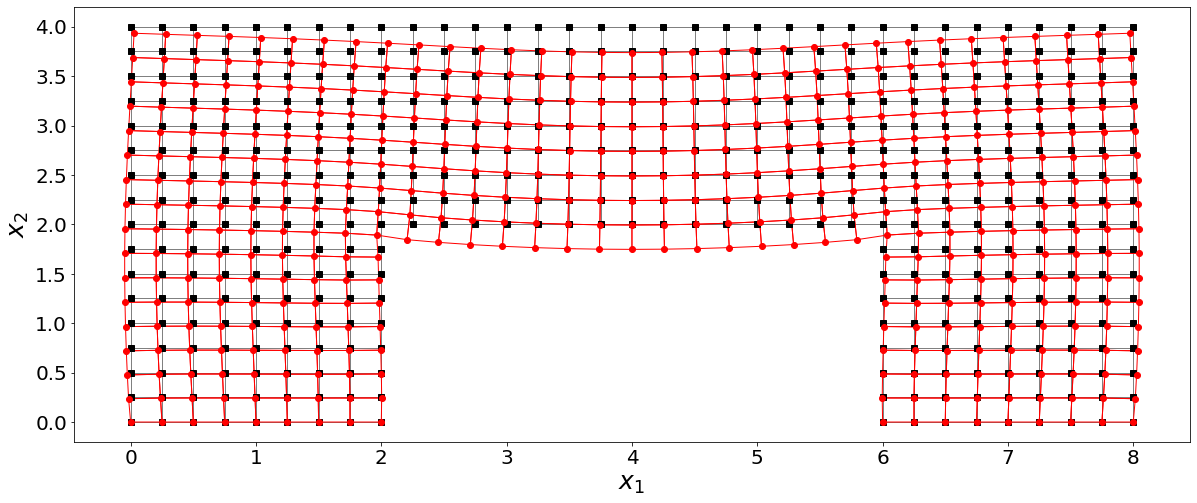

In [14]:
# # Display each individual element displacements
scalar = 5e7 # Displacements tiny so scaled for visualisation

if mesh_density_lvl <= 6:
    new_grid_plot(XYZ, CON, d_reshape, scalar, mesh_density_lvl)

## STRESS AND STRAINS

At integration points:

### Strain
$$
\mathbf{\epsilon}^e_{Ip} = \begin{bmatrix}
\epsilon^e_{11}\\
\epsilon^e_{22}\\
\gamma^e_{12}\\
\end{bmatrix}_{\left(\xi_{i}, \eta_{j}\right)}
= \mathbf{B}^e \left(\xi_{i}, \eta_{j}\right) \mathbf d^{e}
$$

### Stress
$$
\mathbf{\sigma}^e_{Ip} = \begin{bmatrix}
\sigma^e_{11}\\
\sigma^e_{22}\\
\sigma^e_{12}\\
\end{bmatrix}_{\left(\xi_{i}, \eta_{j}\right)}
= \mathbf{C}^e \mathbf{\epsilon} \left(\xi_{i}, \eta_{j}\right)
$$

Overall Element Strain/Stress:

### Strain

$$
\mathbf{\epsilon}^e = \sum_{Ip = 1}^{n_{G} = 4} \mathbf{\epsilon}^e_{Ip} \mathrm{det}\mathbf{J}^e w_{Ip}
$$

### Strain

$$
\mathbf{\sigma}^e = \sum_{Ip = 1}^{n_{G} = 4} \mathbf{\sigma}^e_{Ip} \mathrm{det}\mathbf{J}^e w_{Ip}
$$

In [15]:
### STRESS AND STRAIN AT INTEGRATION POINTS AND FOR ELEMENT
eps = {}
sigma = {}

for i in range(nels):
    
    if 2.0<=XYZ[CON[i, j],0] <6.0 and 0<XYZ[CON[i, j],1]<=2:
        eps[i] = np.zeros((3,1))
        sigma[i] = np.zeros((3,1))
        continue 
       
        
    eps[i] = np.zeros((3,1))
    sigma[i] = np.zeros((3,1))
    
    for j in range(nip):
        eps_ip = np.dot(B[i,j],d[DOF[i]])
        sigma_ip = np.dot(C,eps_ip)
        
        eps[i] += w*eps_ip*detJ[i,j]*th
        sigma[i] += w*sigma_ip*detJ[i,j]*th
        
### STRAIN AND STRESS VOIGT COMPONANTS
eps11 = np.zeros(nels)
eps22 = np.zeros(nels)
gam12 = np.zeros(nels)
for i in range(nels):
    eps11[i] = eps[i][0]
    eps22[i] = eps[i][1]
    gam12[i] = eps[i][2]
    

sigma11 = np.zeros(nels)
sigma22 = np.zeros(nels)
sigma12 = np.zeros(nels)
for i in range(nels):
    sigma11[i] = sigma[i][0]
    sigma22[i] = sigma[i][1]
    sigma12[i] = sigma[i][2]
    
    

## CONTOUR PLOTS

### STRESS AND STRAIN

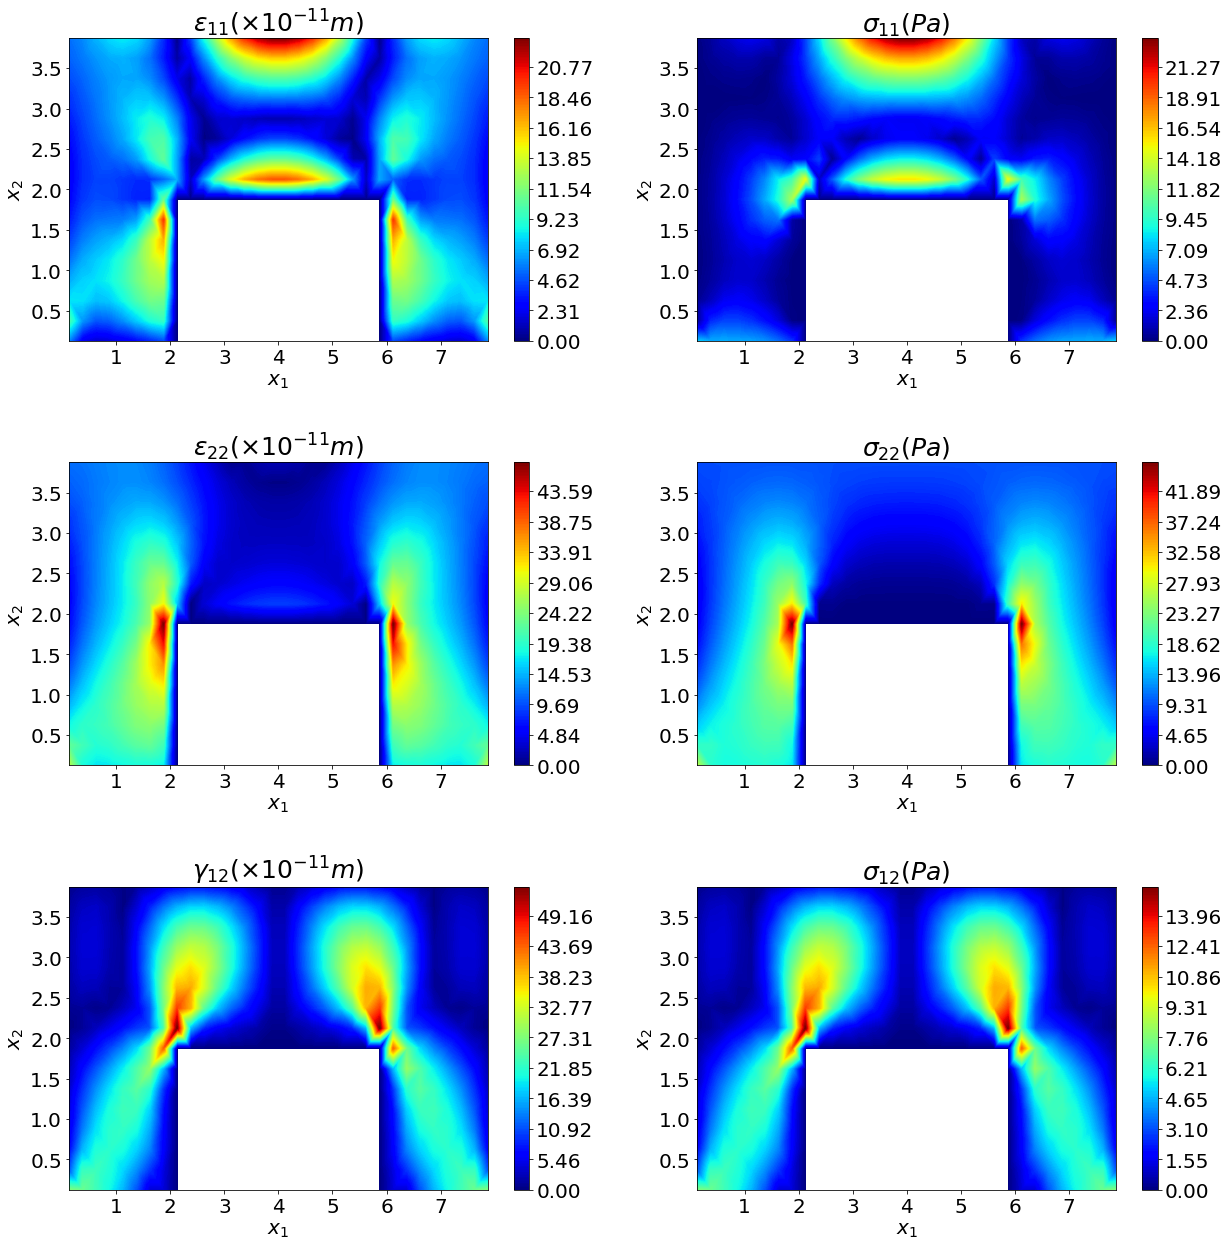

In [16]:
### STRESS/STRAIN DATA
sig11_data = np.abs(np.array(sigma11))
sig22_data = np.abs(np.array(sigma22))
sig12_data = np.abs(np.array(sigma12))

eps11_data = np.abs(np.array(eps11))
eps22_data = np.abs(np.array(eps22))
gam12_data = np.abs(np.array(gam12))


### ELEMENT MIDPOINTS
mid = midpoint(XYZ, CON)
x1 = mid[:,0]
x2 = mid[:,1]

### Z DATA
zeps_data = [eps11_data, eps22_data, gam12_data]

zsig_data = [sig11_data, sig22_data, sig12_data]


### COLOUR MAP RANGE (TOL*MAXVAL, MAXVAL)
tol = 1e-8



### PLOT CONTOUR
if mesh_density_lvl >= 6:
    
    stress_strain_contour(x1, x2, zeps_data, zsig_data, tol, mesh_density_lvl, cmap='jet')


### MAX DISPALCEMENTS

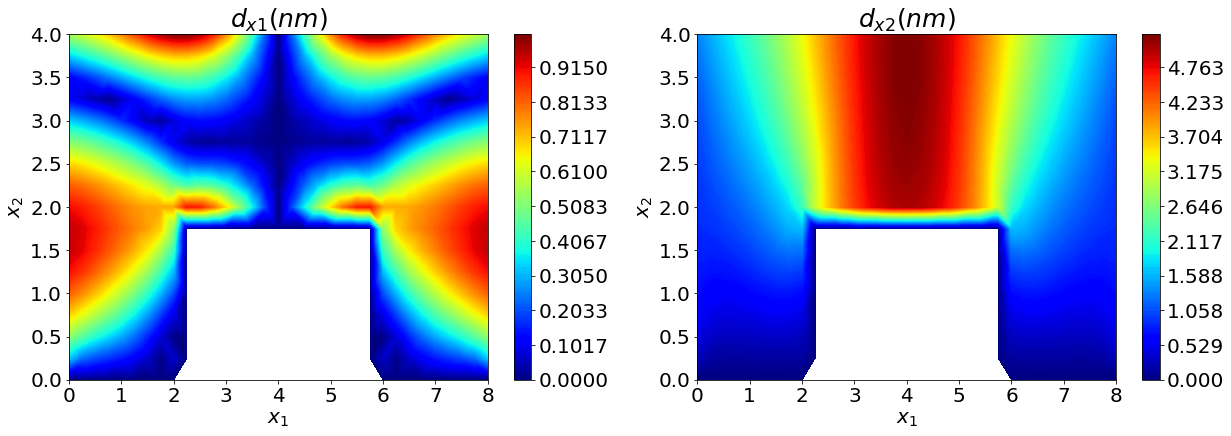

In [17]:
from matplotlib.colors import LogNorm

### POSISITON/DISPLACEMENT NODAL DATA
x1 = np.array([]); x2 = np.array([])
d1 = np.array([]); d2 = np.array([]); mag_d = np.array([])

for i in range(nnodes):
    
    x1 = np.append(x1, XYZ[i][0])
    x2 = np.append(x2, XYZ[i][1])
    
    d1 = np.append(d1, np.abs(d_reshape[i][0]))
    d2 = np.append(d2, np.abs(d_reshape[i][1]))
    
    mag_d = np.append(mag_d, magd[i])

### Z DATA
zdis_data = [d1, d2, mag_d]


### COLOUR MAP RANGE (TOL*MAXVAL, MAXVAL)
tol = 1e-20
 
### PLOT CONTOUR
if mesh_density_lvl >= 6:
    
    displacement_contour(x1, x2, zdis_data , tol, mesh_density_lvl, cmap='jet')



### PRINT MAX STRESS/STRAIN 

In [18]:
### OUTPUT MAX STRESSES AND STRAINS AND THE ELEMENT WHERE THIS OCCURS
max_eps11 = np.argmax(abs(eps11[:]))
max_eps22 = np.argmax(abs(eps22[:]))
max_gam12 = np.argmax(abs(gam12[:]))
print("Max eps11 ",eps11[max_eps11],"at el", max_eps11+1)
print("Max eps22 ",eps22[max_eps22],"at el", max_eps22+1)
print("Max gam12 ",gam12[max_gam12],"at el", max_gam12+1)

max_sigma11 = np.argmax(abs(sigma11[:]))
max_sigma22 = np.argmax(abs(sigma22[:]))
max_sigma12 = np.argmax(abs(sigma12[:]))
print("Max sig11 is",sigma11[max_sigma11],"at el", max_sigma11+1)
print("Max sig22 is",sigma22[max_sigma22],"at el", max_sigma22+1)
print("Max sig12 is",sigma12[max_sigma12],"at el", max_sigma12+1)

Max eps11  -2.2965172507396024e-10 at el 496
Max eps22  -4.819555474884779e-10 at el 232
Max gam12  5.434546811584704e-10 at el 280
Max sig11 is -23.5144653351151 at el 497
Max sig22 is -46.31428871515741 at el 249
Max sig12 is 15.439053442001995 at el 280


In [19]:
### OUTPUT STRESS AND STRAIN FOR A PARTICULAR ELEMENT (SET USING i)
for i in range(nels):
    if i == 0:
        print("element:",i+1)
        print(" eps11:",eps[i][0], "; eps22:",eps[i][1], "; gam12:",eps[i][2])
        print("sigma11:",sigma[i][0], "; sigma22:",sigma[i][1], "; sigma12:",sigma[i][2])

element: 1
 eps11: [5.82217683e-11] ; eps22: [-2.72445799e-10] ; gam12: [-2.71210325e-10]
sigma11: [-7.51134045] ; sigma22: [-26.29927039] ; sigma12: [-7.70483878]


## WRITE DATA TO CSV

### ELEMENT 1 STRESS AND STRAIN

In [20]:
import csv 

header = ['eps_11', 'eps_22', 'gam_12', 'sig_11', 'sig_22', 'sig_12']


data = [float(eps[0][0]), float(eps[0][1]), float(eps[0][2]), float(sigma[0][0]), float(sigma[0][1]), float(sigma[0][2])]



with open('Data_and_Analysis/Element_1_data/el1_shape_'+str(mesh_density_lvl)+'.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerow(data)

### MAX STRESS AND STRAIN

In [21]:
header = ['eps_11', 'eps_22', 'gam_12', 'sig_11', 'sig_22', 'sig_12']


data = [eps11[max_eps11], eps22[max_eps22], gam12[max_gam12], 
        sigma11[max_sigma11], sigma22[max_sigma22], sigma12[max_sigma12]]

data2 = [max_eps11+1, max_eps22+1, max_gam12+1, max_sigma11+1, max_sigma22+1, max_sigma12+1]


with open('Data_and_Analysis/max_strain_stress_data/max_strain_stress_data_shape_'+str(mesh_density_lvl)+'.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerow(data)
    
    writer.writerow(data2)

### MAX DISPLACEMENT

In [22]:
header = ['d_x1', 'd_x2', 'd_x']


data = [d_reshape[maxdx,0], d_reshape[maxdy,1], magd[maxmagd]]

data2 = [maxdx, maxdy, maxmagd]


with open('Data_and_Analysis/max_disp_data/max_disp_data_shape_'+str(mesh_density_lvl)+'.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerow(data)
    
    writer.writerow(data2)    

### REACTION FORCES

$$
\mathbf{K_g}\mathbf{d} = \mathbf{F}
$$

For the bottom fixed boundary (contact) nodes ($n_{Bn}$):

### Reaction force componants 

$$
R_{x_1} = \sum_{n_{Bn}} F_{n_{Bn}, x_1} 
$$
$$
R_{x_2} = \sum_{n_{Bn}} F_{n_{Bn}, x_2} 
$$

### Reaction force direction at contact edge

$$
\theta = \tan^{-1}\left(\frac{R_{x_2}}{R_{x_1}}\right)
$$

### Magnitude of reaction force at contact edge

$$
|\mathbf{R}| = \sqrt{R_{x_1}^{2} + R_{x_2}^{2}}
$$


In [23]:
### FIND ALL NODAL FORCES

F = np.dot(K_g, d)

F = F.reshape((nnodes,2))

### ALL BOUNDARY NODES ARE THE BOTTOM NODES FOR REACTION FORCES
bound = (len(bot))

reaction = F[:bound]

### TOTAL X1 AND X2 COMPONANTS
sum_r1 = 0
sum_r2 = 0

r1 = []
r2 = []

for i in range(len(reaction)):
    if 0.0<=XYZ[i,0]<=2.0:
        continue
    
    r1.append(reaction[i][0])
    r2.append(reaction[i][1])
    sum_r1 += reaction[i][0]
    sum_r2 += reaction[i][1]
    
### MAGNITUDE AT BOUNDARY EDGES
mag_F = np.sqrt(sum_r1**2 + sum_r2**2)

### DURECTION OF REACTION (EQUAL AND OPPOSITE)
angle_1 = np.arctan(sum_r2/sum_r1)*(180/np.pi)
angle_2 = np.arctan(-sum_r2/sum_r1)*(180/np.pi)

header = ['r1', 'r2', 'mag_r', 'angle_1', 'angle_2', 'r1_max', 'r2_max']

data = [sum_r1, sum_r2, mag_F, angle_1, angle_2, np.array(r1).max(), np.array(r2).max()]

with open('Data_and_Analysis/force_data/force_'+str(mesh_density_lvl)+'.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerow(data)
    
